## Задача 1

Реализовать класс для работы с линейной регрессией

In [92]:
import pandas as pd
import numpy as np

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20):
        """
        Инициализация модели линейной регрессии.
        """
        valid_regularizations = [None, 'l1', 'l2', 'l1l2']
        if regularization not in valid_regularizations:
            raise ValueError(f"Недопустимый тип регуляризации: {regularization}. Ожидается один из: {valid_regularizations}")

        valid_weight_calc = ['matrix', 'gd', 'sgd'] # Изменено с 'optimizer' на 'weight_calc'
        if weight_calc not in valid_weight_calc:
            raise ValueError(f"Недопустимый метод расчета весов: {weight_calc}. Ожидается один из: {valid_weight_calc}")

        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise ValueError("Для L1 и L1L2 регуляризации необходимо задать lambda_1.")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise ValueError("Для L2 и L1L2 регуляризации необходимо задать lambda_2.")
        if weight_calc == 'matrix' and regularization in ['l1', 'l1l2']:
            raise ValueError("Матричное решение 'matrix' несовместимо с L1 и L1L2 регуляризацией.")

        self.regularization = regularization
        self.weight_calc = weight_calc  # Здесь используется weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size

        self.w_ = None
        self.coefs_ = None
        self.intercept_ = None

    def _calculate_gradient(self, X, y, weights):
        """
        Вычисляет градиент MSE.
        """
        predictions = X @ weights
        errors = y - predictions
        gradient = -2 * X.T @ errors / X.shape[0]
        return gradient

    def _regularization_gradient(self, weights):
        """
        Вычисляет градиент регуляризационного члена.
        """
        reg_gradient = np.zeros_like(weights)
        feature_weights = weights[:-1]  # Исключаем bias

        if self.regularization == 'l1':
            reg_gradient[:-1] = self.lambda_1 * np.sign(feature_weights)
        elif self.regularization == 'l2':
            reg_gradient[:-1] = 2 * self.lambda_2 * feature_weights
        elif self.regularization == 'l1l2':
            reg_gradient[:-1] = self.lambda_1 * np.sign(feature_weights) + 2 * self.lambda_2 * feature_weights

        return reg_gradient

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        """
        Обучает модель линейной регрессии.
        """
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X

        if isinstance(y, (pd.DataFrame, pd.Series)):
            y_np = y.values.reshape(-1, 1) # Преобразуем y в вектор-столбец
        else:
            y_np = y.reshape(-1, 1)

        X_biased = np.hstack([X_np, np.ones((X_np.shape[0], 1))])

        # Матричное решение
        if self.weight_calc == 'matrix': # Здесь используется weight_calc
            if self.regularization is None:
                try:
                    self.w_ = np.linalg.solve(X_biased.T @ X_biased, X_biased.T @ y_np)
                except np.linalg.LinAlgError:
                    self.w_ = np.linalg.pinv(X_biased.T @ X_biased) @ X_biased.T @ y_np
            elif self.regularization == 'l2':
                I = np.eye(X_biased.shape[1])
                I[-1, -1] = 0
                term1 = X_biased.T @ X_biased + self.lambda_2 * I
                self.w_ = np.linalg.solve(term1, X_biased.T @ y_np)

        # Градиентный спуск (GD / SGD)
        else:
            learning_rate = 0.01
            convergence_threshold = 1e-4
            max_iterations = 2000

            self.w_ = np.zeros((X_biased.shape[1], 1))

            for _ in range(max_iterations):
                weights_prev = self.w_.copy()

                if self.weight_calc == 'gd': # Здесь используется weight_calc
                    grad = self._calculate_gradient(X_biased, y_np, self.w_)
                    if self.regularization:
                        grad += self._regularization_gradient(self.w_)
                    self.w_ -= learning_rate * grad

                elif self.weight_calc == 'sgd': # Здесь используется weight_calc
                    indices = np.arange(X_biased.shape[0])
                    np.random.shuffle(indices)

                    for start_index in range(0, X_biased.shape[0], self.batch_size):
                        batch_indices = indices[start_index : start_index + self.batch_size]
                        X_batch = X_biased[batch_indices]
                        y_batch = y_np[batch_indices]

                        grad = self._calculate_gradient(X_batch, y_batch, self.w_)
                        if self.regularization:
                            grad += self._regularization_gradient(self.w_)
                        self.w_ -= learning_rate * grad

                if np.linalg.norm(self.w_ - weights_prev, ord=2) < convergence_threshold:
                    break

        self.coefs_ = self.w_[:-1].flatten()
        self.intercept_ = self.w_[-1, 0]

        return self

    def predict(self, X: np.array):
        """
        Выполняет предсказание с помощью обученной модели.
        """
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X

        if self.w_ is None:
            raise RuntimeError("Модель не обучена. Используйте метод fit().")

        if X_np.shape[1] == self.w_.shape[0] - 1:
             X_biased = np.hstack([X_np, np.ones((X_np.shape[0], 1))])
        else:
            X_biased = X_np

        if X_biased.shape[1] != self.w_.shape[0]:
            raise ValueError(f"Несоответствие размерностей для предсказания: "
                             f"X_biased.shape[1] ({X_biased.shape[1]}) != self.w_.shape[0] ({self.w_.shape[0]})")

        return (X_biased @ self.w_).flatten()

    def score(self, X: np.array, y: np.array):
        """
        Вычисляет коэффициент детерминации (R²).
        """
        try:
            y_pred = self.predict(X)
        except RuntimeError:
            return np.nan

        ss_res = np.sum((y - y_pred) ** 2)
        y_mean = np.mean(y)
        ss_tot = np.sum((y - y_mean) ** 2)

        if ss_tot == 0:
            return 1.0 if ss_res == 0 else 0.0

        return 1 - (ss_res / ss_tot)

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [93]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
df_cars = pd.read_csv('/content/drive/MyDrive/магистратура/1 сем/матстат/лабы/lab4/Used_fiat_500_in_Italy_dataset.csv')

In [95]:
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
transmission_mapping = {'manual': 0, 'automatic': 1}
df_cars.replace(transmission_mapping, inplace=True)
df_cars_encoded = pd.get_dummies(df_cars, drop_first=True, dtype=int)

X_all = df_cars_encoded.drop(columns=['price'])
y_all = df_cars_encoded['price']

/tmp/ipython-input-948057207.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cars.replace(transmission_mapping, inplace=True)


In [97]:
def analyze_multicollinearity(dataframe_x):
    """Выводит факторы инфляции дисперсии (VIF) для признаков."""
    vif_results = pd.DataFrame()
    vif_results["Feature"] = dataframe_x.columns
    vif_results["VIF"] = [variance_inflation_factor(dataframe_x.values, i) for i in range(dataframe_x.shape[1])]
    vif_results['Sqrt_VIF'] = vif_results['VIF'] ** 0.5
    print("\n--- Анализ мультиколлинеарности (VIF) ---")
    return vif_results.sort_values(by='VIF', ascending=False)

print(analyze_multicollinearity(X_all))


--- Анализ мультиколлинеарности (VIF) ---
           Feature        VIF  Sqrt_VIF
5              lat  70.906390  8.420593
0     engine_power  61.809090  7.861876
6              lon  20.488122  4.526381
2      age_in_days  15.500890  3.937117
3               km  13.746980  3.707692
4  previous_owners   8.408613  2.899761
7        model_pop   1.540092  1.241005
8      model_sport   1.439794  1.199914
1     transmission   1.088142  1.043140
9       model_star   1.019702  1.009803


In [98]:
# Удаление признаков с высоким VIF
features_to_drop = ['lat', 'engine_power']
X_processed = X_all.drop(columns=[col for col in features_to_drop if col in X_all.columns], errors='ignore')

# --- Разделение данных и масштабирование ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_all, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_np = X_train_scaled
X_test_np = X_test_scaled

# --- Настройка гиперпараметров ---
L1_REG_STRENGTH = 0.001
L2_REG_STRENGTH = 0.001
MAX_ITERATIONS_GD = 2000
CONVERGENCE_TOL = 1e-4

In [99]:
# --- Функция для проведения сравнения моделей ---
def run_comparison(model_list, X_train, y_train, X_test, y_test):
    """Обучает и тестирует список моделей, собирая метрики."""
    results = []
    trained_models_for_coefs = {} # Словарь для сохранения обученных моделей

    for m in model_list:
        name = m['name']
        model = m['model']

        start_time = time.time()
        train_time = np.nan
        r2 = np.nan
        rmse = np.nan
        max_coef = np.nan
        coefs = None

        try:
            model.w_ = None # Сбрасываем веса перед обучением
            model.fit(X_train, y_train)
            train_time = time.time() - start_time

            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            if hasattr(model, 'coefs_') and model.coefs_ is not None:
                max_coef = np.max(np.abs(model.coefs_))
                coefs = model.coefs_
            elif hasattr(model, 'coef_') and model.coef_ is not None: # Для sklearn
                max_coef = np.max(np.abs(model.coef_))
                coefs = model.coef_

            trained_models_for_coefs[name] = model

        except Exception as e:
            print(f"Ошибка при обучении {name}: {e}")

        results.append({
            'Model': name,
            'Optimization': m['model'].weight_calc if hasattr(m['model'], 'weight_calc') else 'Solver', # Используем weight_calc
            'Training Time (s)': train_time,
            'R2 Score': r2,
            'RMSE': rmse,
            'Max Feature Coef Abs': max_coef,
            'Coefficients': coefs
        })

    return pd.DataFrame(results).sort_values(by='R2 Score', ascending=False), trained_models_for_coefs

In [100]:
# --- Запуск сравнения моделей ---

print("\n--- Сравнение моделей: Базовые (без регуляризации) ---")
models_base = [
    {'name': 'MyLR (Matrix, No Reg)', 'model': MyLinearRegression(weight_calc='matrix', regularization=None), 'optimizer_type': 'Matrix'}, # weight_calc='matrix'
    {'name': 'MyLR (GD, No Reg)', 'model': MyLinearRegression(weight_calc='gd'), 'optimizer_type': 'GD'}, # weight_calc='gd'
    {'name': 'MyLR (SGD, No Reg)', 'model': MyLinearRegression(weight_calc='sgd', batch_size=32), 'optimizer_type': 'SGD'}, # weight_calc='sgd'
    {'name': 'Sklearn LinearRegression', 'model': LinearRegression(), 'optimizer_type': 'Solver'}
]
results_base, trained_models_base = run_comparison(models_base, X_train_np, y_train, X_test_np, y_test)
print(results_base.to_markdown(index=False, floatfmt=".4f"))

print("\n--- Сравнение моделей: L1 Регуляризация (Lasso) ---")
models_l1 = [
    {'name': 'MyLR (GD, L1)', 'model': MyLinearRegression(weight_calc='gd', regularization='l1', lambda_1=L1_REG_STRENGTH), 'optimizer_type': 'GD'}, # weight_calc='gd'
    {'name': 'MyLR (SGD, L1)', 'model': MyLinearRegression(weight_calc='sgd', regularization='l1', lambda_1=L1_REG_STRENGTH, batch_size=32), 'optimizer_type': 'SGD'}, # weight_calc='sgd'
    {'name': 'Sklearn Lasso', 'model': Lasso(alpha=L1_REG_STRENGTH, max_iter=MAX_ITERATIONS_GD, tol=CONVERGENCE_TOL, random_state=42), 'optimizer_type': 'Solver'},
    {'name': 'Sklearn SGDRegressor (L1)', 'model': SGDRegressor(penalty='l1', alpha=L1_REG_STRENGTH, max_iter=MAX_ITERATIONS_GD, tol=CONVERGENCE_TOL, random_state=42), 'optimizer_type': 'SGD'}
]
results_l1, trained_models_l1 = run_comparison(models_l1, X_train_np, y_train, X_test_np, y_test)
print(results_l1.to_markdown(index=False, floatfmt=".4f"))

print("\n--- Сравнение моделей: L2 Регуляризация (Ridge) ---")
models_l2 = [
    {'name': 'MyLR (Matrix, L2)', 'model': MyLinearRegression(weight_calc='matrix', regularization='l2', lambda_2=L2_REG_STRENGTH), 'optimizer_type': 'Matrix'}, # weight_calc='matrix'
    {'name': 'MyLR (GD, L2)', 'model': MyLinearRegression(weight_calc='gd', regularization='l2', lambda_2=L2_REG_STRENGTH), 'optimizer_type': 'GD'}, # weight_calc='gd'
    {'name': 'MyLR (SGD, L2)', 'model': MyLinearRegression(weight_calc='sgd', regularization='l2', lambda_2=L2_REG_STRENGTH, batch_size=32), 'optimizer_type': 'SGD'}, # weight_calc='sgd'
    {'name': 'Sklearn Ridge', 'model': Ridge(alpha=L2_REG_STRENGTH), 'optimizer_type': 'Solver'}
]
results_l2, trained_models_l2 = run_comparison(models_l2, X_train_np, y_train, X_test_np, y_test)
print(results_l2.to_markdown(index=False, floatfmt=".4f"))


--- Сравнение моделей: Базовые (без регуляризации) ---
| Model                    | Optimization   |   Training Time (s) |   R2 Score |     RMSE |   Max Feature Coef Abs | Coefficients                                                      |
|:-------------------------|:---------------|--------------------:|-----------:|---------:|-----------------------:|:------------------------------------------------------------------|
| Sklearn LinearRegression | Solver         |              0.0055 |     0.8846 | 767.4835 |              1542.9402 | [ 4.11420707e-01 -1.54294019e+03 -5.29641936e+02  4.40491478e+01  |
|                          |                |                     |            |          |                        |   9.44883181e+01  4.25916129e+01  6.82013386e+01  4.37950337e+01] |
| MyLR (Matrix, No Reg)    | matrix         |              0.0004 |     0.8846 | 767.4835 |              1542.9402 | [ 4.11420707e-01 -1.54294019e+03 -5.29641936e+02  4.40491478e+01  |
|                  

In [101]:
# Объединяем все результаты
results_combined = pd.concat([results_base, results_l1, results_l2], ignore_index=True)

/tmp/ipython-input-3771940132.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])


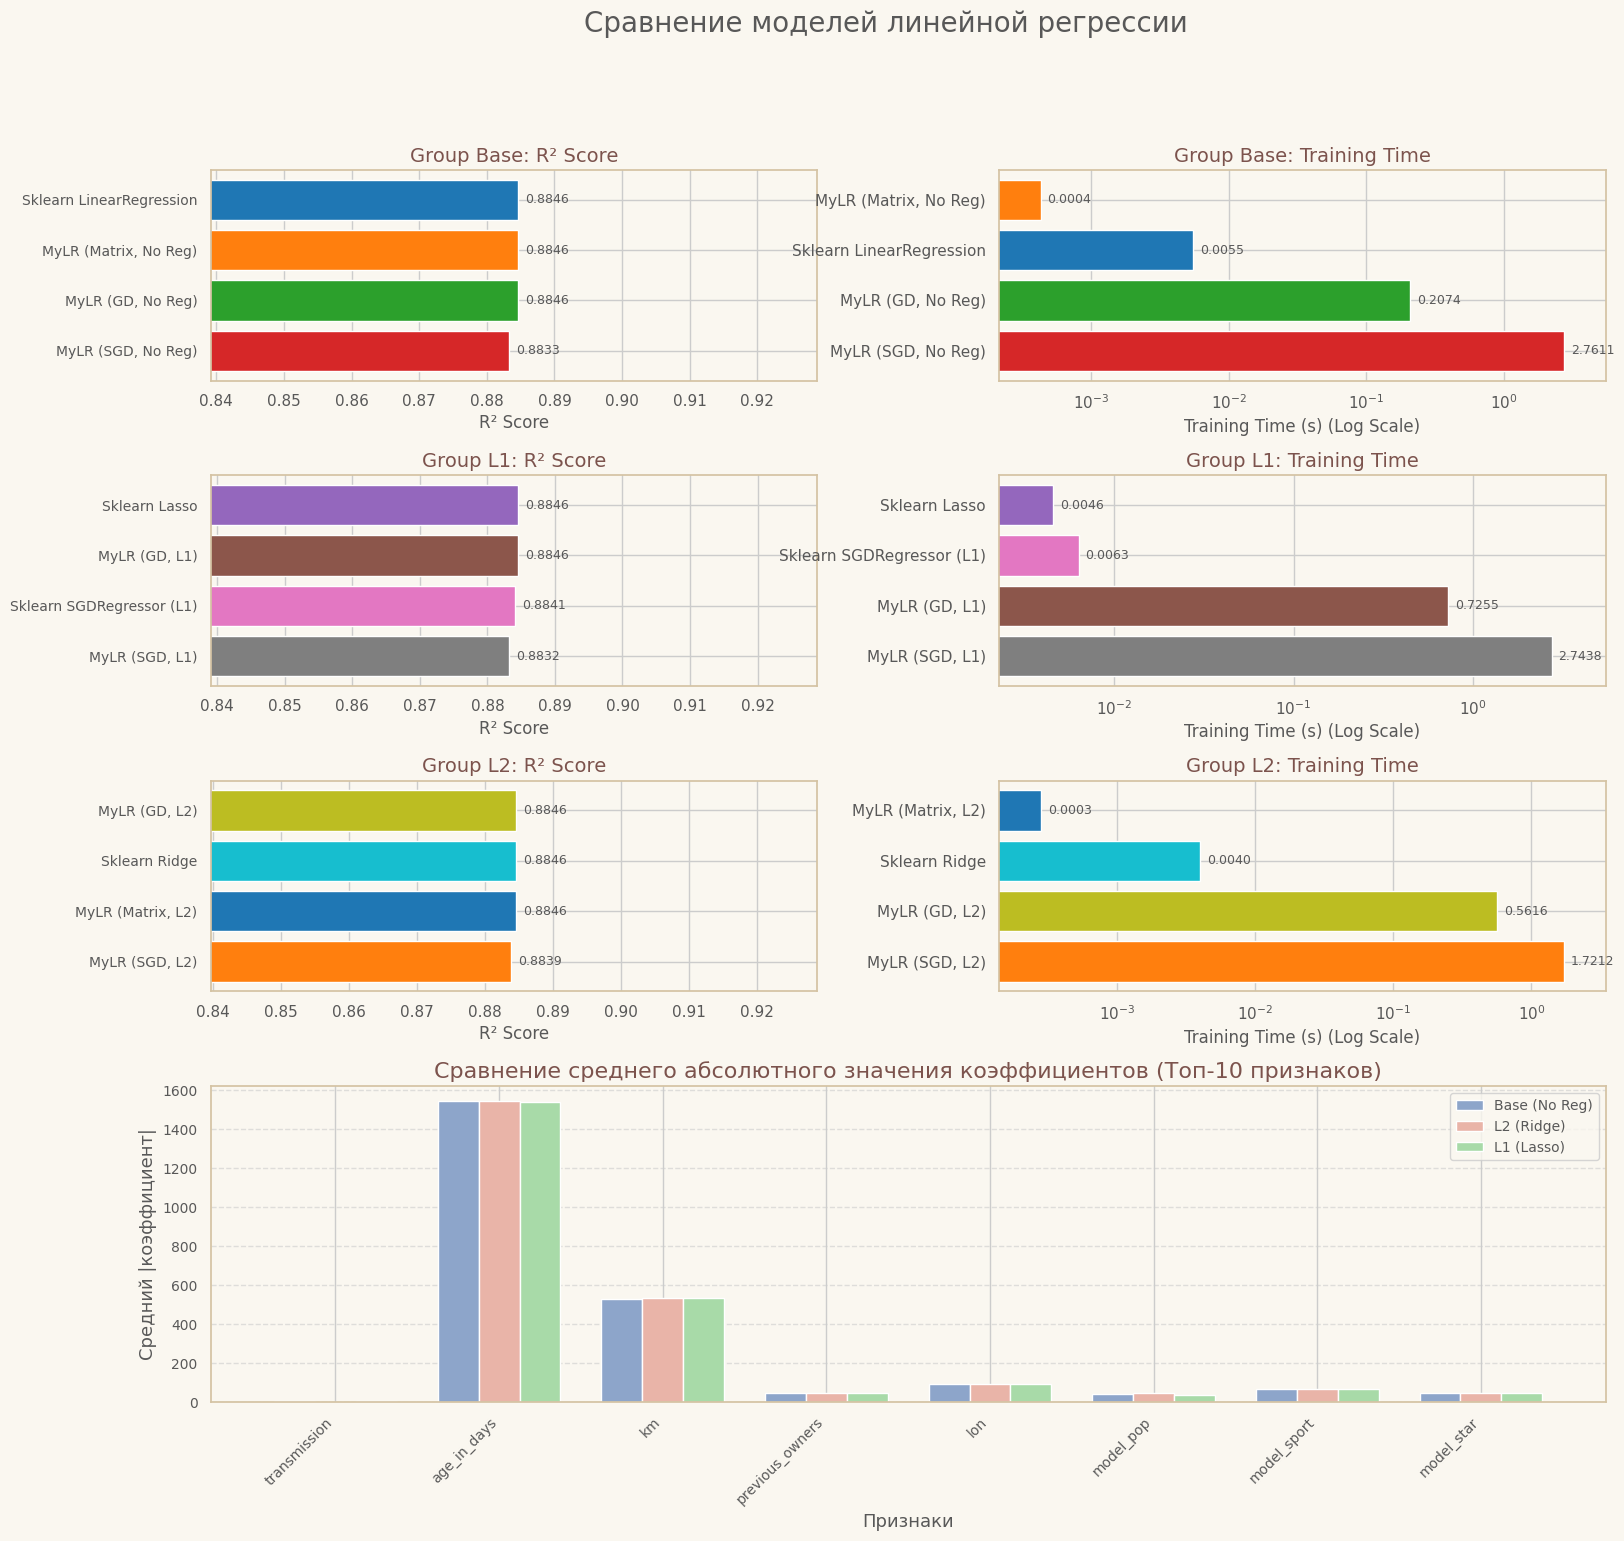

In [104]:
# --- Визуализация результатов ---

sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#FAF7F0", "figure.facecolor": "#FAF7F0",
                                      "text.color": "#585858", "xtick.color": "#585858",
                                      "ytick.color": "#585858", "axes.labelcolor": "#585858",
                                      "axes.edgecolor": "#D4C3A3"})

color_palette = sns.color_palette("tab10")
model_colors = {name: color_palette[i % len(color_palette)] for i, name in enumerate(results_combined['Model'].unique())}
results_combined['Color'] = results_combined['Model'].map(model_colors)

def get_regularization_group(model_name):
    if "L1" in model_name or "Lasso" in model_name:
        return "L1"
    elif "L2" in model_name or "Ridge" in model_name:
        return "L2"
    return "Base"

results_combined["Regularization Group"] = results_combined["Model"].apply(get_regularization_group)
groups_order = ["Base", "L1", "L2"]
feature_names = X_train.columns.tolist()

fig_comparison = plt.figure(figsize=(18, 16))
grid_layout = fig_comparison.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1.5], hspace=0.4, wspace=0.3)
fig_comparison.suptitle("Сравнение моделей линейной регрессии", fontsize=20, color='#585858')

# 1. Графики R² и Времени обучения
for i, group in enumerate(groups_order):
    df_group = results_combined[results_combined["Regularization Group"] == group].copy()

    # График R²
    ax_r2 = fig_comparison.add_subplot(grid_layout[i, 0])
    df_sorted_r2 = df_group.sort_values(by="R2 Score", ascending=True)
    df_sorted_r2_valid = df_sorted_r2.dropna(subset=['R2 Score'])
    bars_r2 = ax_r2.barh(df_sorted_r2_valid["Model"], df_sorted_r2_valid["R2 Score"], color=df_sorted_r2_valid["Color"])
    ax_r2.set_title(f"Group {group}: R² Score", fontsize=14, color='#7C534D')
    ax_r2.set_xlabel("R² Score", fontsize=12)
    ax_r2.tick_params(axis='y', labelsize=10)
    ax_r2.bar_label(bars_r2, fmt='%.4f', padding=5, fontsize=9)
    ax_r2.set_xlim(df_sorted_r2_valid["R2 Score"].min() * 0.95 if not df_sorted_r2_valid.empty else 0.8,
                   df_sorted_r2_valid["R2 Score"].max() * 1.05 if not df_sorted_r2_valid.empty else 0.95)

    # График времени обучения
    ax_time = fig_comparison.add_subplot(grid_layout[i, 1])
    df_sorted_time = df_group.sort_values(by="Training Time (s)", ascending=False)
    df_sorted_time_valid = df_sorted_time.dropna(subset=['Training Time (s)'])
    bars_time = ax_time.barh(df_sorted_time_valid["Model"], df_sorted_time_valid["Training Time (s)"], color=df_sorted_time_valid["Color"])
    ax_time.set_title(f"Group {group}: Training Time", fontsize=14, color='#7C534D')
    ax_time.set_xlabel("Training Time (s) (Log Scale)", fontsize=12)
    ax_time.set_xscale("log")

    min_time_for_log = df_sorted_time_valid["Training Time (s)"].replace(0, np.finfo(float).eps).min() if not df_sorted_time_valid.empty else 1e-6
    ax_time.set_xlim(min_time_for_log * 0.5, df_sorted_time_valid["Training Time (s)"].max() * 2 if not df_sorted_time_valid.empty else 10)
    ax_time.bar_label(bars_time, fmt='%.4f', padding=5, fontsize=9)


# 2. График важности признаков
ax_feature_importance = fig_comparison.add_subplot(grid_layout[3, :])

coefs_no_reg = []
coefs_l1_reg = []
coefs_l2_reg = []

for index, row in results_combined.iterrows():
    coefs = row.get('Coefficients')
    group = row.get('Regularization Group')

    if coefs is not None and isinstance(coefs, np.ndarray) and coefs.ndim == 1 and group is not None:
        if group == 'Base':
            coefs_no_reg.append(coefs)
        elif group == 'L1':
            coefs_l1_reg.append(coefs)
        elif group == 'L2':
            coefs_l2_reg.append(coefs)

if coefs_no_reg or coefs_l1_reg or coefs_l2_reg:
    def calculate_mean_abs_coefs(coef_list, num_features):
        if not coef_list:
            return np.zeros(num_features)

        all_coefs = np.array(coef_list)
        return np.mean(np.abs(all_coefs), axis=0)

    num_features = len(feature_names)
    mean_coefs_no_reg = calculate_mean_abs_coefs(coefs_no_reg, num_features)
    mean_coefs_l1 = calculate_mean_abs_coefs(coefs_l1_reg, num_features)
    mean_coefs_l2 = calculate_mean_abs_coefs(coefs_l2_reg, num_features)

    top_n_features = 10
    if num_features > top_n_features:
        abs_mean_coefs = np.abs(mean_coefs_no_reg)
        top_feature_indices = np.argsort(abs_mean_coefs)[-top_n_features:][::-1]

        feature_names_subset = [feature_names[i] for i in top_feature_indices]
        mean_coefs_no_reg_subset = mean_coefs_no_reg[top_feature_indices]
        mean_coefs_l1_subset = mean_coefs_l1[top_feature_indices]
        mean_coefs_l2_subset = mean_coefs_l2[top_feature_indices]
    else:
        feature_names_subset = feature_names
        mean_coefs_no_reg_subset = mean_coefs_no_reg
        mean_coefs_l1_subset = mean_coefs_l1
        mean_coefs_l2_subset = mean_coefs_l2

    x_positions = np.arange(len(feature_names_subset))
    width = 0.25

    ax_feature_importance.bar(x_positions - width, mean_coefs_no_reg_subset, width, label='Base (No Reg)', color='#8DA5CA')
    ax_feature_importance.bar(x_positions, mean_coefs_l2_subset, width, label='L2 (Ridge)', color='#E9B4A8')
    ax_feature_importance.bar(x_positions + width, mean_coefs_l1_subset, width, label='L1 (Lasso)', color='#A8DAA8')

    ax_feature_importance.set_title("Сравнение среднего абсолютного значения коэффициентов (Топ-10 признаков)", fontsize=16, color='#7C534D')
    ax_feature_importance.set_xlabel("Признаки", fontsize=13)
    ax_feature_importance.set_ylabel("Средний |коэффициент|", fontsize=13)
    ax_feature_importance.set_xticks(x_positions)
    ax_feature_importance.set_xticklabels(feature_names_subset, rotation=45, ha='right', fontsize=10)
    ax_feature_importance.legend(fontsize=10)
    ax_feature_importance.grid(axis='y', linestyle='--', alpha=0.6)
    ax_feature_importance.tick_params(axis='both', labelsize=10)

else:
    print("Предупреждение: Не удалось получить коэффициенты для построения графика важности признаков.")

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)